In [62]:
import pandas as pd
import pathlib
from pathlib import Path
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import seaborn as sns


In [23]:
work_path = pathlib.Path.cwd()
data_path = Path(work_path, 'data', 'Telco-Customer-Churn.csv')
data = pd.read_csv(data_path)


In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


# EDA

In [25]:
data['Churn'] = np.where(data['Churn'] == 'Yes', 1, 0)
data['Partner'] = np.where(data['Partner'] == 'Yes', 1, 0)
data['Dependents'] = np.where(data['Dependents'] == 'Yes', 1, 0)
data['PhoneService'] = np.where(data['PhoneService'] == 'Yes', 1, 0)
data['PaperlessBilling'] = np.where(data['PaperlessBilling'] == 'Yes', 1, 0)
data['gender'] = np.where(data['gender'] == 'Male', 1, 0)

In [26]:
two_categorical_column = []
other_categorical_column = []
for column in data.columns[1:-3].drop('tenure'):
    if len(data[column].unique()) == 2:
        two_categorical_column.append(column)
    else:
        other_categorical_column.append(column)
    print('Количество уникальных значений {0} = {1}'.format(column, data[column].unique()))

Количество уникальных значений gender = [0 1]
Количество уникальных значений SeniorCitizen = [0 1]
Количество уникальных значений Partner = [1 0]
Количество уникальных значений Dependents = [0 1]
Количество уникальных значений PhoneService = [0 1]
Количество уникальных значений MultipleLines = ['No phone service' 'No' 'Yes']
Количество уникальных значений InternetService = ['DSL' 'Fiber optic' 'No']
Количество уникальных значений OnlineSecurity = ['No' 'Yes' 'No internet service']
Количество уникальных значений OnlineBackup = ['Yes' 'No' 'No internet service']
Количество уникальных значений DeviceProtection = ['No' 'Yes' 'No internet service']
Количество уникальных значений TechSupport = ['No' 'Yes' 'No internet service']
Количество уникальных значений StreamingTV = ['No' 'Yes' 'No internet service']
Количество уникальных значений StreamingMovies = ['No' 'Yes' 'No internet service']
Количество уникальных значений Contract = ['Month-to-month' 'One year' 'Two year']
Количество уникальных

In [27]:
ohe = OneHotEncoder()
ohe_data = pd.DataFrame(ohe.fit_transform(data[other_categorical_column]).toarray(), columns=ohe.get_feature_names_out())

In [28]:
data.drop(other_categorical_column + ['customerID'], axis=1, inplace=True)
data = pd.concat([data, ohe_data], axis=1)

In [29]:
data.loc[data.TotalCharges == ' ', 'TotalCharges'] = np.nan
data.dropna(axis=0, inplace=True)
data['TotalCharges'] = data['TotalCharges'].astype(float)
#data['TotalCharges'].fillna((data['TotalCharges'].mode()), inplace=True)

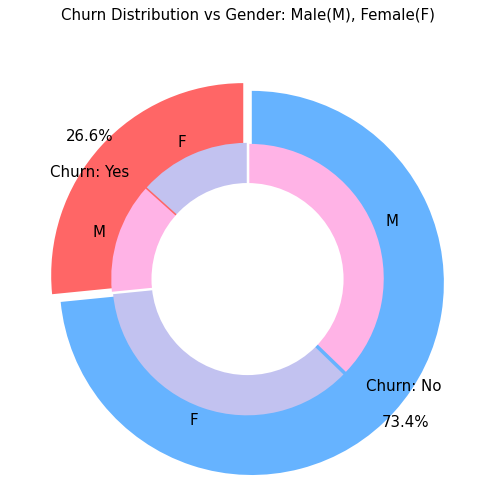

In [30]:
plt.figure(figsize=(7, 7))
labels =["Churn: Yes","Churn: No"]
values = [1869,5163]
labels_gender = ["F","M","F","M"]
sizes_gender = [939, 930, 2544, 2619]
colors = ['#ff6666', '#66b3ff']
colors_gender = ['#c2c2f0','#ffb3e6', '#c2c2f0','#ffb3e6']
explode = (0.3, 0.3) 
explode_gender = (0.1, 0.1, 0.1, 0.1)
textprops = {"fontsize":15}
#Plot
plt.pie(values, labels=labels, autopct='%1.1f%%', pctdistance=1.08, labeldistance=0.8,colors=colors, startangle=90,frame=True, explode=explode,radius=10, textprops =textprops, counterclock = True, )
plt.pie(sizes_gender, labels=labels_gender, colors=colors_gender, startangle=90, explode=explode_gender,radius=7, textprops =textprops, counterclock = True, )

#Draw circle
centre_circle = plt.Circle((0,0),5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Churn Distribution vs Gender: Male(M), Female(F)', fontsize=15, y=1.1)

# show plot 
 
plt.axis('equal')
plt.tight_layout()
plt.show()

# Машинное обучение

In [31]:
X = data.drop('Churn', axis=1)
y = data['Churn']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, random_state=42)

# Случайный лес

In [33]:
# Создание экземпляра класса RandomForestClassifier
forest = RandomForestClassifier()

In [34]:
# Количество деревьев
n_estimators = [int(x) for x in np.linspace(100, 1200, 10)]
# Число признаков для выбора расщепления
max_features = ['auto', 'sqrt']
# Максимальная глубина деревьев
max_depth = [int(x) for x in np.linspace(3, 20, 6)]
# Минимальное число объектов, при котором выполняется расщепление
min_samples_split = [2, 5, 10, 15, 100]
# Ограничение на число объектов в листьях
min_samples_leaf = [1, 2, 5, 10]

# Сетка гиперпараметров 
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

print(random_grid)

In [35]:
# Сетка гиперпараметров 
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

print(random_grid)

{'n_estimators': [100, 222, 344, 466, 588, 711, 833, 955, 1077, 1200], 'max_features': ['auto', 'sqrt'], 'max_depth': [3, 6, 9, 13, 16, 20], 'min_samples_split': [2, 5, 10, 15, 100], 'min_samples_leaf': [1, 2, 5, 10]}


In [36]:
random_grid = RandomizedSearchCV(estimator = forest, param_distributions = random_grid, n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs =-1)
# Обучение модели
random_grid.fit(X_train,y_train)
print(f'Лучшие параметры модели: {random_grid.best_params_}')
print(f'Лучший результат: {random_grid.best_score_}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Лучшие параметры модели: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 9}
Лучший результат: 0.8062219304477637


In [58]:
forest = RandomForestClassifier(n_estimators=100, min_samples_split=5, 
random_state=0, min_samples_leaf=2, max_features='sqrt', max_depth=15)
forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, max_features='sqrt', min_samples_leaf=2,
                       min_samples_split=5, random_state=0)

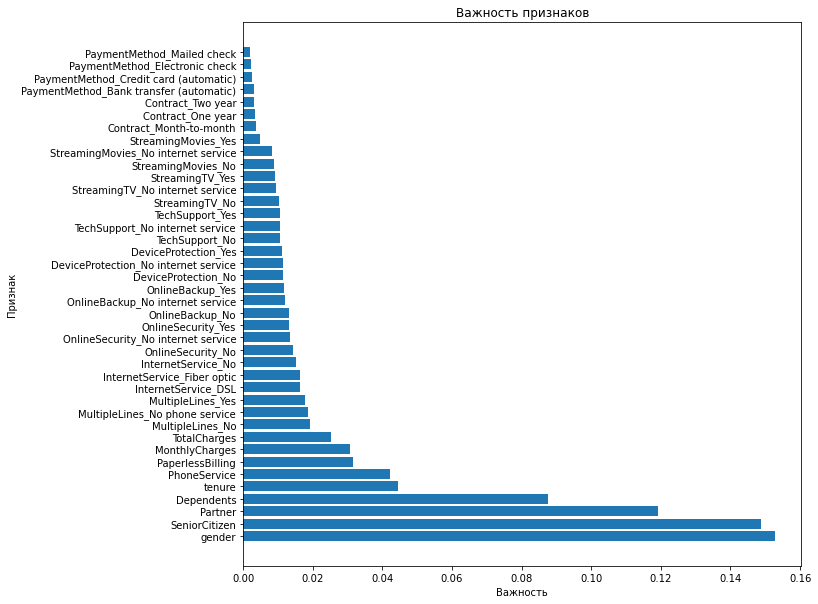

In [59]:
importance = pd.DataFrame({'features': X.columns, 'feature_importances_':forest.feature_importances_,})
importance = importance.sort_values(by='feature_importances_', ascending=False)
import matplotlib.pyplot as plt
from importlib import reload
plt=reload(plt)
def plot_feature_importances_cancer(data):
    n_features = X_train.shape[1]
    plt.figure(figsize=(10, 10))
    plt.barh(np.arange(n_features), data.feature_importances_)
    plt.yticks(np.arange(n_features), X.columns)
    plt.ylabel("Признак")
    plt.xlabel('Важность')
    plt.title('Важность признаков')

plot_feature_importances_cancer(importance)


In [60]:
# Предсказание модели на тестовых данных
predict_forest = forest.predict(X_test)

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1300
           1       0.63      0.49      0.55       458

    accuracy                           0.79      1758
   macro avg       0.73      0.69      0.71      1758
weighted avg       0.78      0.79      0.78      1758



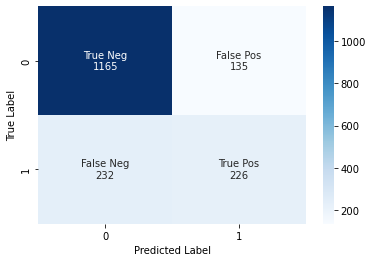

In [77]:
group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]

labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]

labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label');

print(classification_report(y_test, predict_forest))

In [56]:
predictions = forest.predict(X_test)

In [57]:

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test, predictions))
print(accuracy_score(y_test, predictions))

[[1181  119]
 [ 250  208]]
              precision    recall  f1-score   support

           0       0.83      0.91      0.86      1300
           1       0.64      0.45      0.53       458

    accuracy                           0.79      1758
   macro avg       0.73      0.68      0.70      1758
weighted avg       0.78      0.79      0.78      1758

0.7901023890784983


# Метод к ближайщих соседей

In [43]:

error_rate=list()
#here we iterate meny different k values and plot their error rates 
#and discover which one is better than others and has the lowest error rate
for i in range(1, 40):
    knn=KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    prediction_i=knn.predict(X_test)
    error_rate.append(np.mean(prediction_i != y_test))

Text(0, 0.5, 'Error Rate')

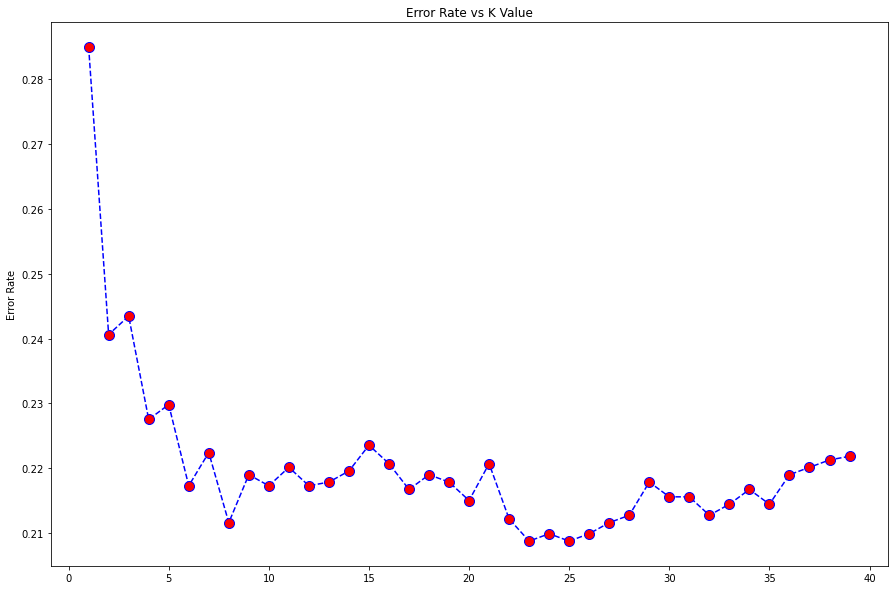

In [44]:

plt.figure(figsize=(15,10))
plt.plot(range(1,40),error_rate, color="blue", linestyle="--",marker="o",markerfacecolor="red",markersize=10)
plt.title("Error Rate vs K Value")
plt.xlabel="K Value"
plt.ylabel("Error Rate")

In [45]:
knn=KNeighborsClassifier(n_neighbors=23)
knn.fit(X_train, y_train)
predictions=knn.predict(X_test)

In [46]:
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test, predictions))
print(accuracy_score(y_test, predictions))

[[1214   86]
 [ 281  177]]
              precision    recall  f1-score   support

           0       0.81      0.93      0.87      1300
           1       0.67      0.39      0.49       458

    accuracy                           0.79      1758
   macro avg       0.74      0.66      0.68      1758
weighted avg       0.78      0.79      0.77      1758

0.7912400455062572


# Дерево решений

In [47]:

dtree=DecisionTreeClassifier()
dtree.fit(X_train,y_train)

DecisionTreeClassifier()

In [48]:
print(tree.export_text(dtree))

|--- feature_33 <= 0.50
|   |--- feature_7 <= 93.67
|   |   |--- feature_35 <= 0.50
|   |   |   |--- feature_32 <= 0.50
|   |   |   |   |--- feature_38 <= 0.50
|   |   |   |   |   |--- feature_8 <= 37.08
|   |   |   |   |   |   |--- feature_8 <= 35.35
|   |   |   |   |   |   |   |--- feature_7 <= 19.47
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- feature_7 >  19.47
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- feature_8 >  35.35
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- feature_8 >  37.08
|   |   |   |   |   |   |--- feature_7 <= 60.27
|   |   |   |   |   |   |   |--- feature_15 <= 0.50
|   |   |   |   |   |   |   |   |--- feature_8 <= 231.75
|   |   |   |   |   |   |   |   |   |--- feature_8 <= 229.18
|   |   |   |   |   |   |   |   |   |   |--- feature_6 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |   |--- feature_6 >  0.50
|   |   |   |   

In [49]:
predictions = dtree.predict(X_test)
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test, predictions))
print(accuracy_score(y_test, predictions))

[[1044  256]
 [ 216  242]]
              precision    recall  f1-score   support

           0       0.83      0.80      0.82      1300
           1       0.49      0.53      0.51       458

    accuracy                           0.73      1758
   macro avg       0.66      0.67      0.66      1758
weighted avg       0.74      0.73      0.74      1758

0.7315130830489193


# Метод опорных векторов

In [50]:



param_grid={"C":[1,5,10],"gamma":[1, 0.01, 0.001]} 
#here we select values for grid search to try
grid=GridSearchCV(SVC(),param_grid,verbose=2)
grid.fit(X_train,y_train)



Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END .......................................C=1, gamma=1; total time=   3.6s
[CV] END .......................................C=1, gamma=1; total time=   3.7s
[CV] END .......................................C=1, gamma=1; total time=   4.0s
[CV] END .......................................C=1, gamma=1; total time=   3.8s
[CV] END .......................................C=1, gamma=1; total time=   3.6s
[CV] END ....................................C=1, gamma=0.01; total time=   3.1s
[CV] END ....................................C=1, gamma=0.01; total time=   3.7s
[CV] END ....................................C=1, gamma=0.01; total time=   2.9s
[CV] END ....................................C=1, gamma=0.01; total time=   2.9s
[CV] END ....................................C=1, gamma=0.01; total time=   2.8s
[CV] END ...................................C=1, gamma=0.001; total time=   1.9s
[CV] END ...................................C=1, 

GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 5, 10], 'gamma': [1, 0.01, 0.001]},
             verbose=2)

In [51]:
print(grid.best_params_)
print(grid.best_estimator_)

{'C': 1, 'gamma': 0.001}
SVC(C=1, gamma=0.001)


In [52]:
grid_predictions=grid.predict(X_test)
print(confusion_matrix(y_test,grid_predictions))
print(classification_report(y_test, grid_predictions))
print(accuracy_score(y_test, grid_predictions))

[[1188  112]
 [ 268  190]]
              precision    recall  f1-score   support

           0       0.82      0.91      0.86      1300
           1       0.63      0.41      0.50       458

    accuracy                           0.78      1758
   macro avg       0.72      0.66      0.68      1758
weighted avg       0.77      0.78      0.77      1758

0.7838452787258248


# Логистическая регрессия

In [53]:
Lr = LogisticRegression(C=1)
Lr.fit(X_train, y_train)

LogisticRegression(C=1)

In [54]:
predict = Lr.predict(X_test)

In [55]:
confusion_matrix(predict, y_test)

array([[1165,  226],
       [ 135,  232]], dtype=int64)